In [49]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Input, GRU
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler

In [50]:
def draw_prediction(Y, Y_pred, time_offset=0):
    names = ["Egg", "Larva", "Pupa", "Fertile Male Adult", "Fertile Female Adult", "Sterile Female Adult", "Mated Female Adult"]
    fig, axs = plt.subplots(2, 4, figsize=(15, 10), constrained_layout=False)
    axs = axs.flatten()
    time_interval = [time_offset + k for k in range(len(Y))]
    max_val = max(np.max(Y), np.max(Y_pred))
    for i in range(7):
        ax = axs[i]
        ax.plot(time_interval, Y[:, i])
        ax.plot(time_interval, Y_pred[:, i], linestyle='--')
        ax.set_title(names[i])
        ax.set_xlim(time_interval[0], time_interval[-1])
        ax.set_ylim(0, max_val)
    plt.show()

def Y_inverse_transform(Y, scaler):
    res = scaler.inverse_transform(np.c_[Y[:, :5], np.zeros(Y.shape[0]), Y[:, 5:]])
    return np.c_[res[:, :5], res[:, 6:]]

In [102]:
def plot_model(model):
    history = model.history
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

## Dense

In [51]:
def read_dataset(folder, N):
    X_list = []
    Y_list = []
    data_list = []

    N_digit = len(str(N))

    for i in range(N):
        filename = f"{folder}/{i:0{N_digit}d}.csv"
        data = pl.read_csv(filename).drop("Time").to_numpy()
        data_list.append(data)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(np.concatenate(data_list))

    for data in data_list:
        data_trans = scaler.transform(data)
        X, Y = data_trans[:-1, :], np.c_[data_trans[1:, :5], data_trans[1:, 6:]]
        X_list.append(X)
        Y_list.append(Y)

    X = np.concatenate(X_list)
    Y = np.concatenate(Y_list)

    return X, Y, scaler

def read_test(filename, scaler):
    data = pl.read_csv(filename).drop("Time").to_numpy()
    data_trans = scaler.transform(data)
    X, Y = data_trans[:-1, :], np.c_[data_trans[1:, :5], data_trans[1:, 6:]]
    return X, Y

In [82]:
X_train, Y_train, scaler_train = read_dataset("../dataset/01/train", 100)
X_test, Y_test, scaler_test = read_dataset("../dataset/01/test", 1)

In [72]:
model_dense = Sequential([
    Input(shape=(8,)),
    Dense(128, activation="relu"),
    Dense(7, activation="sigmoid")
])
model_dense.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,055 (8.03 KB)

 Trainable params: 2,055 (8.03 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
model_dense.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
checkpoint = ModelCheckpoint(
    "best_model.keras",  # Filepath to save the best model
    monitor="val_loss",  # Metric to monitor (e.g., validation accuracy)
    save_best_only=True,  # Save only the best model
    mode="min",  # "max" if monitoring validation accuracy, "min" for loss
    verbose=0  # Display messages when saving
)
model_dense.fit(X_train, Y_train, epochs=50, batch_size=75, validation_split=0.2, verbose=0, callbacks=[checkpoint])

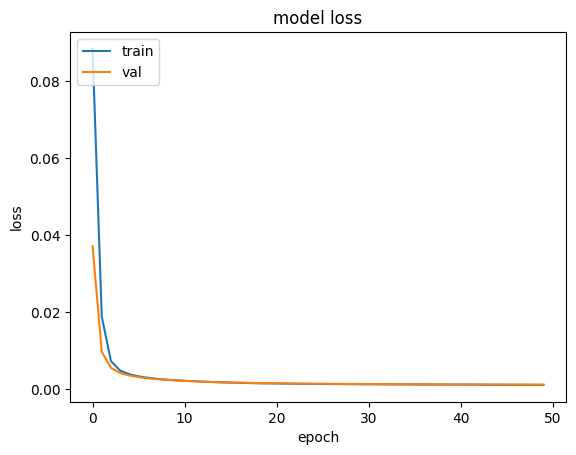

In [104]:
max(model_dense.history.history["val_accuracy"])
plot_model(model_dense)

In [83]:
Y_pred = model_dense.predict(X_test, verbose=0)
Y_pred = Y_inverse_transform(Y_pred, scaler_test)
Y_real = Y_inverse_transform(Y_test, scaler_test)

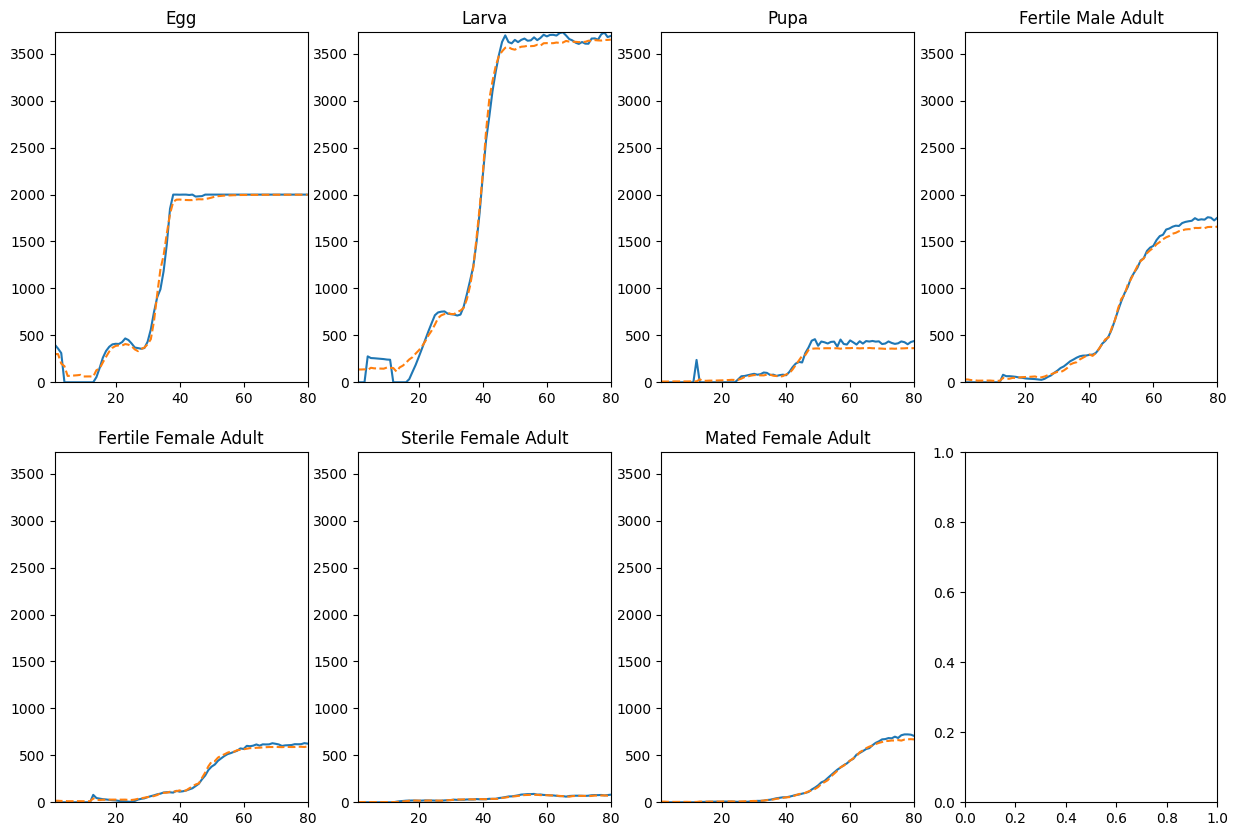

In [84]:
draw_prediction(Y_real[:80], Y_pred[:80], time_offset=1)

## GRU

In [85]:
LOOK_BACK = 10

In [86]:
def add_look_back(data):
    X, y = [], []
    for i in range(len(data)-LOOK_BACK-1):
        X.append(data[i:i+LOOK_BACK])
        y.append(np.delete(data[i+LOOK_BACK], 5, 0))
    return np.array(X), np.array(y)

In [89]:
def read_dataset(folder, N):
    X_list = []
    Y_list = []
    data_list = []

    N_digit = len(str(N))

    for i in range(N):
        filename = f"{folder}/{i:0{N_digit}d}.csv"
        data = pl.read_csv(filename).drop("Time").to_numpy()
        data_list.append(data)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(np.concatenate(data_list))

    for data in data_list:
        X, Y = add_look_back(scaler.transform(data))
        X_list.append(X)
        Y_list.append(Y)

    X = np.concatenate(X_list)
    Y = np.concatenate(Y_list)

    return X, Y, scaler

In [90]:
X_train, Y_train, scaler_train = read_dataset("../dataset/01/train", 100)
X_test, Y_test, scaler_test = read_dataset("../dataset/01/test", 1)

In [91]:
model_gru = Sequential([
    Input(shape=(LOOK_BACK, 8)),
    GRU(50, return_sequences=True),
    GRU(50),
    Dense(7, activation="sigmoid")
])
model_gru.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 10, 50)         │         9,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 7)              │           357 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,657 (96.32 KB)

 Trainable params: 24,657 (96.32 KB)

 Non-trainable params: 0 (0.00 B)

In [97]:
model_gru.compile(optimizer='adam', loss='mean_squared_error')
model_gru.fit(X_train, Y_train, epochs=50, batch_size=75, validation_split=0.2, verbose=0, callbacks=[checkpoint])

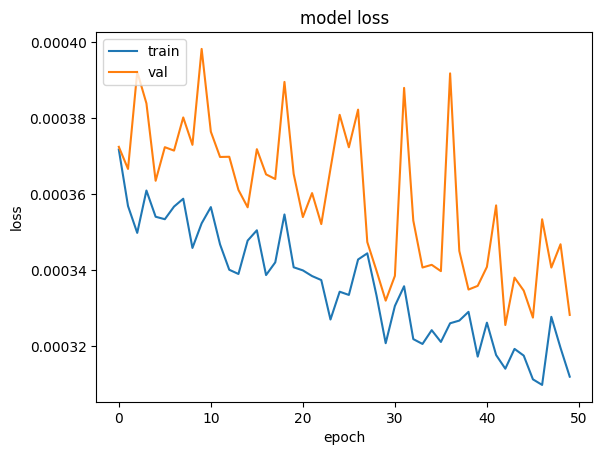

In [103]:
min(model_gru.history.history["val_loss"])
plot_model(model_gru)

In [124]:
def slide_prediction(X_init, predict_fun, N):
    Y = []
    X = X_init
    for i in range(N):
        new_Y = predict_fun(X.reshape(1, LOOK_BACK, 8))[0]
        Y.append(new_Y)
        new_X = np.zeros_like(X)
        new_X[:LOOK_BACK-1, :] = X[1:, :]
        new_X[LOOK_BACK-1, :] = np.insert(new_Y, 5, 0)
        X = np.copy(new_X)
    return np.array(Y)


In [93]:
Y_pred = model_gru.predict(X_test, verbose=0)
Y_pred = Y_inverse_transform(Y_pred, scaler_test)
Y_real = Y_inverse_transform(Y_test, scaler_test)
Y_pred.shape

(70, 7)

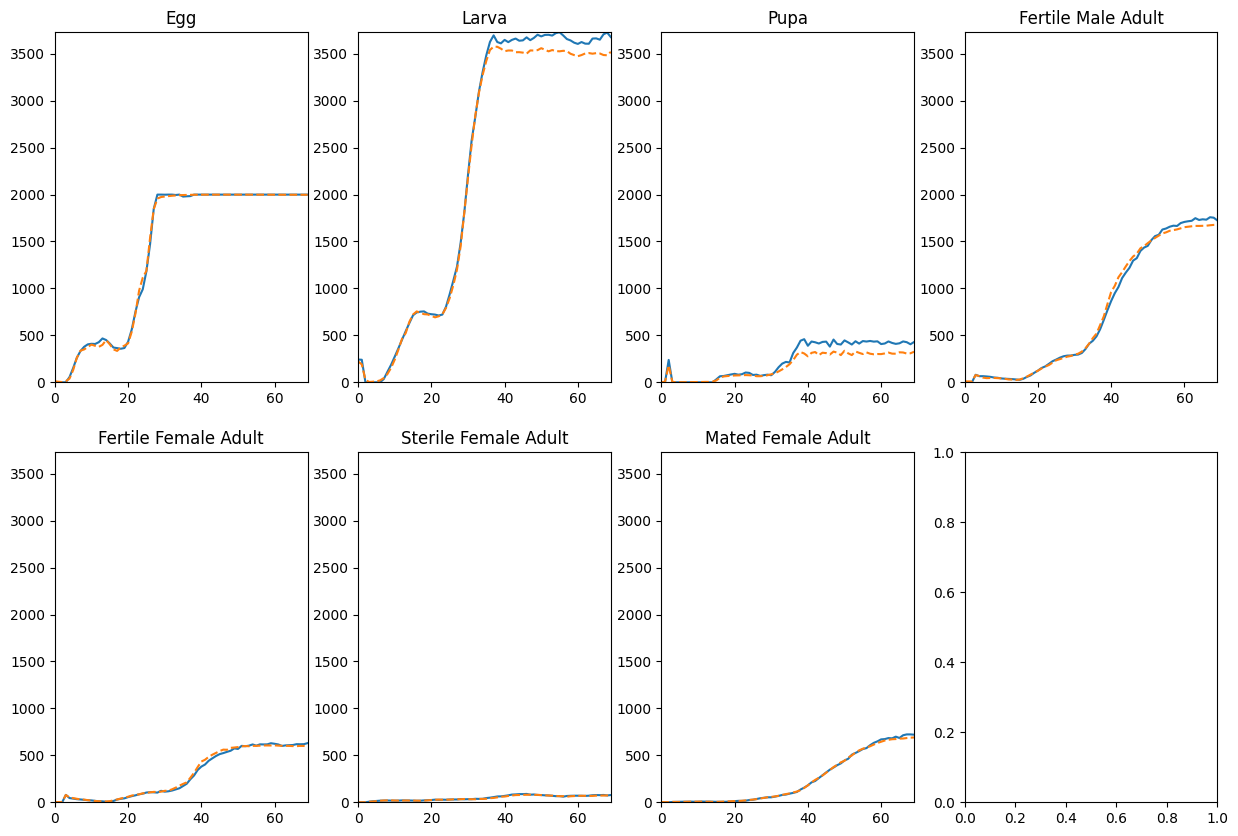

In [94]:
draw_prediction(Y_real[:70], Y_pred[:70])

array([[3.69167607e-03, 2.32477095e-02, 4.69917012e-03, 1.63420662e-03,
        1.73116126e-03, 5.34340506e-03, 5.39996661e-04],
       [2.10086629e-03, 1.57065392e-02, 7.85322115e-03, 1.75526424e-03,
        1.67688495e-03, 3.60065582e-03, 4.58324736e-04],
       [1.23004650e-03, 7.81059172e-03, 2.36722112e-01, 7.67471222e-03,
        1.32592749e-02, 5.45306504e-03, 9.01309249e-04],
       [4.32561990e-03, 1.26034347e-03, 9.67045315e-03, 3.14455740e-02,
        8.57817829e-02, 3.58006321e-02, 2.59648240e-03],
       [6.46080449e-03, 1.63919572e-03, 3.05437506e-03, 2.97478493e-02,
        7.27451816e-02, 5.44111021e-02, 3.98235908e-03],
       [9.15718358e-03, 1.79476291e-03, 3.10203014e-03, 3.75701413e-02,
        9.86490771e-02, 8.63471925e-02, 5.45298960e-03],
       [1.26265353e-02, 2.11563287e-03, 2.97091086e-03, 4.57115620e-02,
        1.23375505e-01, 1.36881530e-01, 7.44398497e-03],
       [1.72850732e-02, 2.54068198e-03, 2.93962308e-03, 5.46393394e-02,
        1.44468114e-01, 2